# Test of the "grand neutrino" collectivisation implementation

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from classy import Class
from time import perf_counter

In [2]:
from scipy.interpolate import interp1d
def interp_onto(xdata, ydata, xonto):
    interp = interp1d(xdata, ydata)
    return interp(xonto)

In [3]:
masses = [1, 2, 3]
degs   = [1, 1, 1]
Nbins = 30

standard_settings = {
    'H0': 70.0,
    'Omega_cdm': 0.26,
    # etc...
    
    'N_ncdm': len(masses),
    'm_ncdm': ', '.join([str(i) for i in masses]),
    'deg_ncdm': ', '.join([str(i) for i in degs]),

    'Quadrature strategy': '3, 3, 3',
    'Maximum_q': '8, 8, 8',
    'Number of momentum bins': f'{Nbins}, {Nbins}, {Nbins}',
    
    'output_ncdm_binning': 0,
#    'output': 'tCl',
#    'ncdm_fluid_approximation': 0,
}

In [4]:
separate = Class()
separate.set(standard_settings)
tic = perf_counter()
separate.compute()
toc = perf_counter()
print(f"Computed {len(masses)} separate species in {toc - tic:.5} s")

collective = Class()
collective.set(standard_settings | {'collective_ncdm': 1})
tic = perf_counter()
collective.compute()
toc = perf_counter()
print(f"Computed {len(masses)} collective species in {toc - tic:.5} s")

Computed 3 separate species in 0.074207 s
Computed 3 collective species in 0.042382 s


Pretty OK speed-up, about factor 2 in background.

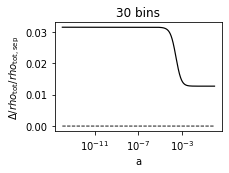

In [12]:
bg_sep, bg_col = separate.get_background(), collective.get_background()
a_sep = 1/(1 + bg_sep['z'])
a_col = 1/(1 + bg_col['z'])
rho_tot_sep = interp_onto(a_sep, np.sum(np.vstack([bg_sep[f'(.)rho_ncdm[{idx}]'] for idx in range(len(masses))]), axis=0), a_col)

fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.set_title(f'{Nbins} bins')
ax.set(xlabel='a', ylabel=r'$\Delta /rho_\mathrm{tot}/rho_\mathrm{tot,sep}$', xscale='log', yscale='linear')
ax.plot(a_col, (bg_col['(.)rho_ncdm[0]'] - rho_tot_sep)/rho_tot_sep, 'k-', lw=1.2)
ax.plot(a_col, np.zeros(len(a_col)), 'k--', lw=0.9)

In [9]:
def get_ini_rho_error(Nbins, strategy=3):
    separate = Class()
    separate.set(standard_settings | {'Number of momentum bins': f'{Nbins}, {Nbins}, {Nbins}', 'Quadrature strategy': f'{strategy}, {strategy}, {strategy}'})
    separate.compute()

    collective = Class()
    collective.set(standard_settings | {'collective_ncdm': 1, 'Number of momentum bins': f'{Nbins}, {Nbins}, {Nbins}', 'Quadrature strategy': f'{strategy}, {strategy}, {strategy}'})
    collective.compute()

    bg_sep, bg_col = separate.get_background(), collective.get_background()
    a_sep = 1/(1 + bg_sep['z'])
    a_col = 1/(1 + bg_col['z'])
    rho_tot_sep = interp_onto(a_sep, np.sum(np.vstack([bg_sep[f'(.)rho_ncdm[{idx}]'] for idx in range(len(masses))]), axis=0), a_col)

    error = (bg_col['(.)rho_ncdm[0]'] - rho_tot_sep)/rho_tot_sep
    return error[0]

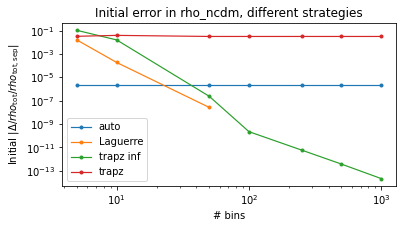

In [10]:
binlist = [5, 10, 50, 100, 250, 500, 1000]
laguerre_cut = 100
errorlist_auto = [get_ini_rho_error(bins, strategy=0) for bins in binlist]
errorlist_laguerre = [get_ini_rho_error(bins, strategy=1) for bins in binlist if bins < laguerre_cut]
errorlist_trapz_inf = [get_ini_rho_error(bins, strategy=2) for bins in binlist]
errorlist_trapz = [get_ini_rho_error(bins, strategy=3) for bins in binlist]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.set_title(f'Initial error in rho_ncdm, different strategies')
ax.set(xlabel='# bins', ylabel=r'Initial $|\Delta /rho_\mathrm{tot}/rho_\mathrm{tot,sep}|$', xscale='log', yscale='log')
ax.plot(binlist, np.abs(errorlist_auto), '.-', lw=1.2, label='auto')
ax.plot([b for b in binlist if b < laguerre_cut], np.abs(errorlist_laguerre), '.-', lw=1.2, label='Laguerre')
ax.plot(binlist, np.abs(errorlist_trapz_inf), '.-', lw=1.2, label='trapz inf')
ax.plot(binlist, np.abs(errorlist_trapz), '.-', lw=1.2, label='trapz')
ax.legend()

In [ ]:
def get_binning(Nbins, strategy=3):
    collective = Class()
    collective.set(standard_settings | {'collective_ncdm': 1, 'output_ncdm_binning': 1, 'Number of momentum bins': f'{Nbins}, {Nbins}, {Nbins}', 'Quadrature strategy': f'{strategy}, {strategy}, {strategy}'})
    collective.compute()
    bg = collective.get_background()
    qlist = [bg[f'q_ncdm[0][{idx}]'][0] for idx in range(Nbins)]
    wlist = [bg[f'w_ncdm[0][{idx}]'][0] for idx in range(Nbins)]
    return np.array(qlist), np.array(wlist)
    

In [ ]:
bins = 30

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.set_title(f'collective distribution function, m={masses}, {bins} bins')
ax.set(xlabel='q', ylabel=r'$q^2 f(q) \ dq$', xscale='linear', yscale='linear')

q_auto, w_auto = get_binning(bins, strategy=0)
ax.plot(q_auto, q_auto**2*w_auto, '.-', lw=1.2, label='auto')

q_lag, w_lag = get_binning(bins, strategy=1)
ax.plot(q_lag, q_lag**2*w_lag, '.-', lw=1.2, label='Gauss-Laguerre')

q_trapz_inf, w_trapz_inf = get_binning(bins, strategy=2)
ax.plot(q_trapz_inf, q_trapz_inf**2*w_trapz_inf, '.-', lw=1.2, label='Trapz inf')

q_trapz, w_trapz = get_binning(bins, strategy=3)
ax.plot(q_trapz, q_trapz**2*w_trapz, '.-', lw=1.2, label='Trapz')

ax.set(xlim=[0, 8])
ax.legend()

# Perturbations

Massive speed-up in perturbations! About a factor 4 when including perturbations!